In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
#sys.path.append("..")
#import utils
import pickle
import copy
import csv
from datetime import datetime
import time
from io import StringIO
from tqdm import tqdm as tqdm
from dateutil import parser

D2C_MIN = 2000 #meters

In [39]:
LAT_MIN = 17.4068
LAT_MAX = 31.4648
LON_MIN = -98.0539
LON_MAX = -80.4332

dataset_path = "data/"
l_csv_filename =["AIS_2020_03_20_COVID.csv"]
#l_csv_filename =["Est-aruba_5x5deg_2018001_2018180.csv"]
pkl_filename = "AIS_2020_03_20_COVID.pkl"
pkl_filename_train = "AIS_2020_03_20_COVID_train_track.pkl"
pkl_filename_valid = "AIS_2020_03_20_COVID_valid_track.pkl"
pkl_filename_test  = "AIS_2020_03_20_COVID_test_track.pkl"

cargo_tanker_filename = "AIS_2020_03_20_COVID_cargo_tanker.npy"

t_train_min = time.mktime(time.strptime("01/01/2020 00:00:00", "%d/%m/%Y %H:%M:%S"))
t_train_max = time.mktime(time.strptime("20/03/2020 17:59:59", "%d/%m/%Y %H:%M:%S"))
t_valid_min = time.mktime(time.strptime("20/03/2020 18:00:00", "%d/%m/%Y %H:%M:%S"))
t_valid_max = time.mktime(time.strptime("20/03/2020 19:59:59", "%d/%m/%Y %H:%M:%S"))
t_test_min  = time.mktime(time.strptime("20/03/2020 20:00:00", "%d/%m/%Y %H:%M:%S"))
t_test_max  = time.mktime(time.strptime("20/03/2020 23:59:59", "%d/%m/%Y %H:%M:%S"))
t_min = time.mktime(time.strptime("01/01/2017 00:00:00", "%d/%m/%Y %H:%M:%S"))
t_max = time.mktime(time.strptime("31/01/2021 23:59:59", "%d/%m/%Y %H:%M:%S"))

#========================================================================
LAT_RANGE = LAT_MAX - LAT_MIN
LON_RANGE = LON_MAX - LON_MIN
SOG_MAX = 30.0  # the SOG is truncated to 30.0 knots max.

EPOCH = datetime(1970, 1, 1)
LAT, LON, SOG, COG, HEADING, TIMESTAMP, MMSI, STATUS, SHIPTYPE  = list(range(9))

CARGO_TANKER_ONLY = True
if  CARGO_TANKER_ONLY:
    pkl_filename = "ct_"+pkl_filename
    pkl_filename_train = "ct_"+pkl_filename_train
    pkl_filename_valid = "ct_"+pkl_filename_valid
    pkl_filename_test  = "ct_"+pkl_filename_test
    
print(pkl_filename_train)


## LOADING CSV FILES
#======================================
l_l_msg = [] # list of AIS messages, each row is a message (list of AIS attributes)
n_error = 0
for csv_filename in l_csv_filename:
    data_path = os.path.join(dataset_path,csv_filename)
    with open(data_path,"r") as f:
        print("Reading ", csv_filename, "...")
        csvReader = csv.reader(f)
        next(csvReader) # skip the legend row
        count = 1
        for row in tqdm(csvReader):
#             utc_time = datetime.strptime(row[8], "%Y/%m/%d %H:%M:%S")
#             timestamp = (utc_time - EPOCH).total_seconds()
            # Format: LAT, LON, SOG, COG, HEADING, TIMESTAMP, MMSI, STATUS, SHIPTYPE
            count += 1
            try:
                l_l_msg.append([float(row[2]),float(row[3]),
                                float(row[4]),float(row[5]),
                                int(float(row[6])),time.mktime(parser.parse(row[1]).timetuple()),
                                int(row[0]), int(row[11]), int(row[10])])
            except:
                n_error += 1
                continue


m_msg = np.array(l_l_msg)
#del l_l_msg
print("Total number of AIS messages: ",m_msg.shape[0])

print("Lat min: ",np.min(m_msg[:,LAT]), "Lat max: ",np.max(m_msg[:,LAT]))
print("Lon min: ",np.min(m_msg[:,LON]), "Lon max: ",np.max(m_msg[:,LON]))
print("Ts min: ",np.min(m_msg[:,TIMESTAMP]), "Ts max: ",np.max(m_msg[:,TIMESTAMP]))

if m_msg[0,TIMESTAMP] > 1584720228: 
    m_msg[:,TIMESTAMP] = m_msg[:,TIMESTAMP]/1000 # Convert to suitable timestamp format

print("Time min: ",datetime.utcfromtimestamp(np.min(m_msg[:,TIMESTAMP])).strftime('%Y-%m-%d %H:%M:%SZ'))
print("Time max: ",datetime.utcfromtimestamp(np.max(m_msg[:,TIMESTAMP])).strftime('%Y-%m-%d %H:%M:%SZ'))


## Vessel Type    
#======================================
print("Selecting vessel type ...")
def sublist(lst1, lst2):
   ls1 = [element for element in lst1 if element in lst2]
   ls2 = [element for element in lst2 if element in lst1]
   return (len(ls1) != 0) and (ls1 == ls2)

VesselTypes = dict()
l_mmsi = []
n_error = 0
for v_msg in tqdm(m_msg):
    try:
        mmsi_ = v_msg[MMSI]
        type_ = v_msg[SHIPTYPE]
        if mmsi_ not in l_mmsi :
            VesselTypes[mmsi_] = [type_]
            l_mmsi.append(mmsi_)
        elif type_ not in VesselTypes[mmsi_]:
            VesselTypes[mmsi_].append(type_)
    except:
        n_error += 1
        continue
print(n_error)
for mmsi_ in tqdm(list(VesselTypes.keys())):
    VesselTypes[mmsi_] = np.sort(VesselTypes[mmsi_])
    
l_cargo_tanker = []
l_fishing = []
for mmsi_ in list(VesselTypes.keys()):
    if sublist(VesselTypes[mmsi_], list(range(70,80))) or sublist(VesselTypes[mmsi_], list(range(80,90))):
        l_cargo_tanker.append(mmsi_)
    if sublist(VesselTypes[mmsi_], [30]):
        l_fishing.append(mmsi_)

print("Total number of vessels: ",len(VesselTypes))
print("Total number of cargos/tankers: ",len(l_cargo_tanker))
print("Total number of fishing: ",len(l_fishing))

ct_AIS_2020_03_20_COVID_train_track.pkl
Reading  AIS_2020_03_20_COVID.csv ...


7267837it [03:34, 33871.70it/s]


Total number of AIS messages:  4926483
Lat min:  0.53827 Lat max:  61.24088
Lon min:  -178.2013 Lon max:  144.67391
Ts min:  1584615600.0 Ts max:  1584701999.0
Time min:  2020-03-19 11:00:00Z
Time max:  2020-03-20 10:59:59Z
Selecting vessel type ...


100%|██████████| 4926483/4926483 [01:45<00:00, 46655.44it/s]


0


100%|██████████| 7489/7489 [00:00<00:00, 818339.48it/s]


Total number of vessels:  7489
Total number of cargos/tankers:  1394
Total number of fishing:  372


In [40]:
print(np.array(l_l_msg).shape)

(4926483, 9)


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Assuming your dataset `data` has shape (6527152, 8)
# Example: Replace with actual data
data = np.array(l_l_msg)
print(Counter(data[:, STATUS]))


Counter({0.0: 2696675, 5.0: 730110, 15.0: 662716, 12.0: 441748, 1.0: 166127, 3.0: 84962, 7.0: 38673, 8.0: 38348, 11.0: 31334, 2.0: 12198, 10.0: 7146, 9.0: 6738, 13.0: 4696, 4.0: 4392, 6.0: 620})


In [106]:
mapping = {
    70: 1,
    80: 2,
    37: 3,
    30: 4
}
last_column = data[:, -1]
mask = (last_column == 30) | ((last_column >= 70) & (last_column <= 89) | (last_column == 37))
vessel_data = data[mask]
features = vessel_data[:, :STATUS]

# Extract the vessel type (last column)
vessel_types = vessel_data[:, -1]  # Assuming vessel types are 0 for cargo tankers, 1 for fishing vessels
random_indices = np.random.choice(features.shape[0], size=10000, replace=False)
features = features[random_indices]
vessel_types = vessel_types[random_indices]

for i in range(len(vessel_types)):
    if vessel_types[i] >= 70 and vessel_types[i] < 80:
        vessel_types[i] = 70
    if vessel_types[i] >= 80:
        vessel_types[i] = 80

for i in range(len(vessel_types)):
    vessel_types[i] = mapping[vessel_types[i]]

c:\Users\jjul482\AppData\Local\anaconda3\envs\adapters\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jjul482\AppData\Local\anaconda3\envs\adapters\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


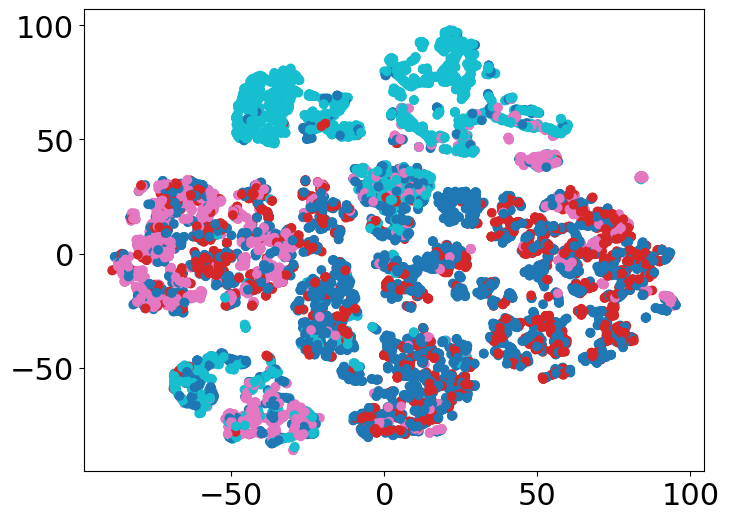

In [107]:
# Standardize the features
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(features_scaled)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=vessel_types, cmap='tab10')

# Add a color bar and legend
#plt.colorbar(scatter, label='Vessel Type')  # Colorbar shows the range of vessel types

# Add a legend
#plt.legend(handles=scatter.legend_elements()[0], labels=["Cargo", "Tanker", "Pleasure Craft", "Fishing"], title="Vessel Type")
plt.savefig('vessel tsne.pdf')

plt.show()

In [117]:
last_column = data[:, STATUS]
print(Counter(data[:, STATUS]))
mask = (last_column != 6) & (last_column != 4) & (last_column < 9)
vessel_data = data[mask]
print(Counter(vessel_data[:, STATUS]))

mapping = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    5: 1,
    7: 2,
    8: 0
}

for i in vessel_data:
    i[STATUS] = mapping[i[STATUS]]

vessel_status = vessel_data[:, STATUS]

unique_statuses = np.unique(vessel_status)
features = vessel_data[:, :STATUS]

# Initialize lists to store the selected indices
selected_indices = []

# For each status type, randomly sample from the available readings
for status in unique_statuses:
    # Get indices of the current status type
    status_indices = np.where(vessel_status == status)[0]
    
    # Randomly select from the current status group
    # Ensure the number of samples is the same for each status (e.g., 1000 samples per status)
    selected_status_indices = np.random.choice(status_indices, size=3000, replace=False)
    
    # Add the selected indices to the list
    selected_indices.extend(selected_status_indices)

# Convert the list of selected indices into a numpy array
selected_indices = np.array(selected_indices)

# Use the selected indices to index the features and vessel_status arrays
features = features[selected_indices]
vessel_status = vessel_status[selected_indices]
print(Counter(vessel_status))

Counter({0.0: 2696675, 5.0: 730110, 15.0: 662716, 12.0: 441748, 1.0: 166127, 3.0: 84962, 7.0: 38673, 8.0: 38348, 11.0: 31334, 2.0: 12198, 10.0: 7146, 9.0: 6738, 13.0: 4696, 4.0: 4392, 6.0: 620})
Counter({0.0: 2696675, 5.0: 730110, 1.0: 166127, 3.0: 84962, 7.0: 38673, 8.0: 38348, 2.0: 12198})
Counter({0.0: 3000, 1.0: 3000, 2.0: 3000})


c:\Users\jjul482\AppData\Local\anaconda3\envs\adapters\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jjul482\AppData\Local\anaconda3\envs\adapters\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


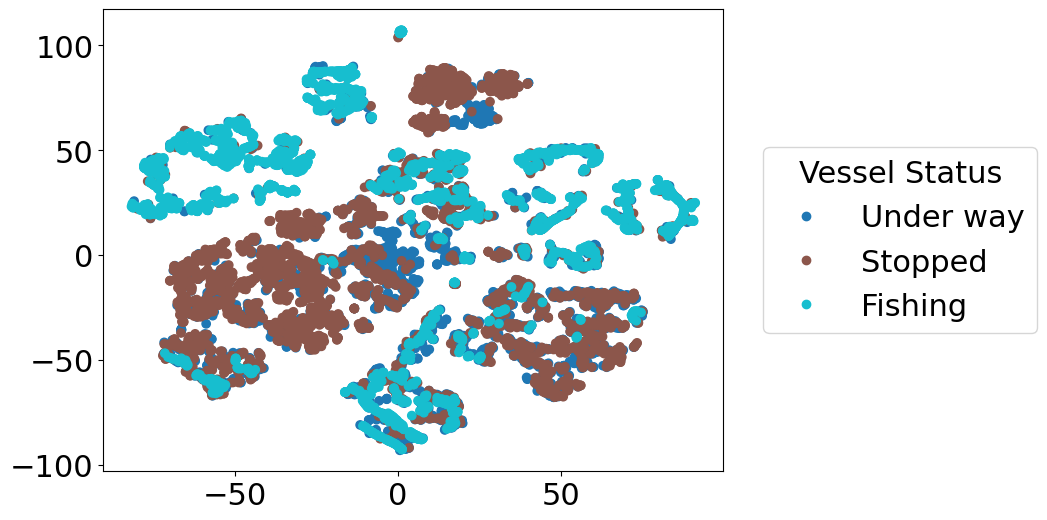

In [121]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(features_scaled)

# Plotting
plt.figure(figsize=(8, 6))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=vessel_status, cmap='tab10')

# Add a color bar and legend
#plt.colorbar(scatter, label='Vessel Type')  # Colorbar shows the range of vessel types

# Add a legend
plt.legend(handles=scatter.legend_elements()[0], labels=["Underway", "Stopped", "Fishing"], title="Vessel Status", bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.savefig('status tsne.pdf')

plt.show()